In [17]:
! pip uninstall pulse2percept -y
! cd pulse2percept && pip install -r requirements.txt && pip install -r requirements-dev.txt && pip install -e .
! pip install tqdm 

Found existing installation: pulse2percept 0.6.0.dev0
Uninstalling pulse2percept-0.6.0.dev0:
  Successfully uninstalled pulse2percept-0.6.0.dev0


Obtaining file:///home/jovyan/work/pulse2percept
  Running setup.py develop for pulse2percept


In [3]:
! pip install Pillow
! pip install Pandas
! pip install sklearn
! pip install scipy

     |████████████████████████████████| 10.1 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 7.1 MB 1.2 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=d0d04cd15b1298372b49435711cfc2ee956b258f1da2dca6c844b21100390743
  Stored in directory: /home/jovyan/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


# Generating Datasets using python multiprocessing

In [9]:
import pulse2percept as p2p
from prima import * 
%matplotlib inline 
import matplotlib.pyplot as plt 
from scipy.ndimage import gaussian_filter

In [10]:
"""
    utilities for generating percepts for a given model/implant with one stimulus point at each pixel
    of magnitude 10
"""
from tqdm import tqdm 
from multiprocessing import Pool

BASE_CURRENT_CONSTANT = 10

def generate_dataset_helper(argpack):
    model, implant, stim_dim, idx = argpack
    stim = np.zeros(stim_dim)
    stim[idx] = BASE_CURRENT_CONSTANT
    implant.stim = stim
    percept = model.predict_percept(implant)
    return percept

def generate_dataset_fast(model, implant, stim_dim, j=8):
    with Pool(j) as p:
        generator = p.imap(generate_dataset_helper, [(model, implant, stim_dim, idx) for idx in range(0, stim_dim)])
        return list(tqdm(generator, total=stim_dim))


def plot_percept(ax, model, percept, title='Predicted percept'):
    ax.imshow(percept, cmap='gray')
    ax.set_xticks(np.linspace(0, percept.shape[1], num=5))
    ax.set_xticklabels(np.linspace(*model.xrange, num=5))
    ax.set_xlabel('x (dva)')
    ax.set_yticks(np.linspace(0, percept.shape[0], num=5))
    ax.set_yticklabels(np.linspace(*model.yrange, num=5))
    ax.set_ylabel('y (dva)')
    ax.set_title(title)



In [11]:
# utility for running PCA on some data 
from sklearn import decomposition
from sklearn import datasets
import numpy as np
import pandas as pd 
from sklearn.preprocessing import *

def run_pca(dataset, percentage=0.95):
    percepts = normalize(np.array([obj.flatten() for obj in dataset]))
    percepts_pca = decomposition.PCA(percentage)
    percepts_pca.fit(percepts)
    components = percepts_pca.transform(percepts)
    projected = percepts_pca.inverse_transform(components)
    return components, projected

In [4]:
# example, generate percepts for ArgusII using AxonMapModel

# model = p2p.models.AxonMapModel(rho=100, axlambda=200)
# model.engine = 'serial'
# model.build()
# implant = p2p.implants.ArgusII()
# output_percepts = generate_dataset_fast(model, implant, 60)

# import pickle
# if output_percepts and len(output_percepts) > 0:
#     with open("./data/ArgusII_percepts.pickle", "wb") as f:
#         pickle.dump(output_percepts, f)

# print("Done generating percepts")

In [5]:
# example, generate percepts for Prima using ScoreboardModel

# from prima import * 
# model = p2p.models.ScoreboardModel(rho=100)
# model.engine = 'serial'
# model.build()
# implant = Prima()
# output_percepts = generate_dataset_fast(model, implant, 400, j=12)
# if output_percepts:
#     with open("./data/Prima20x20_ScoreboardModel_percepts.pickle", "wb") as f:
#         pickle.dump(output_percepts, f)

## Dataset for Scoreboard w/Prima and Argus w/different values of rho

In [6]:
rhos = [25, 50, 75, 100, 125, 150, 200, 300]
rhos_alpha = [50, 100, 150, 200, 300]

rho: 25 argus scoreboard
rho: 25 prima scoreboard
rho: 50 argus scoreboard
rho: 50 prima scoreboard
rho: 75 argus scoreboard
rho: 75 prima scoreboard
rho: 100 argus scoreboard
rho: 100 prima scoreboard
rho: 125 argus scoreboard
rho: 125 prima scoreboard
rho: 150 argus scoreboard
rho: 150 prima scoreboard
rho: 200 argus scoreboard
rho: 200 prima scoreboard
rho: 300 argus scoreboard
rho: 300 prima scoreboard


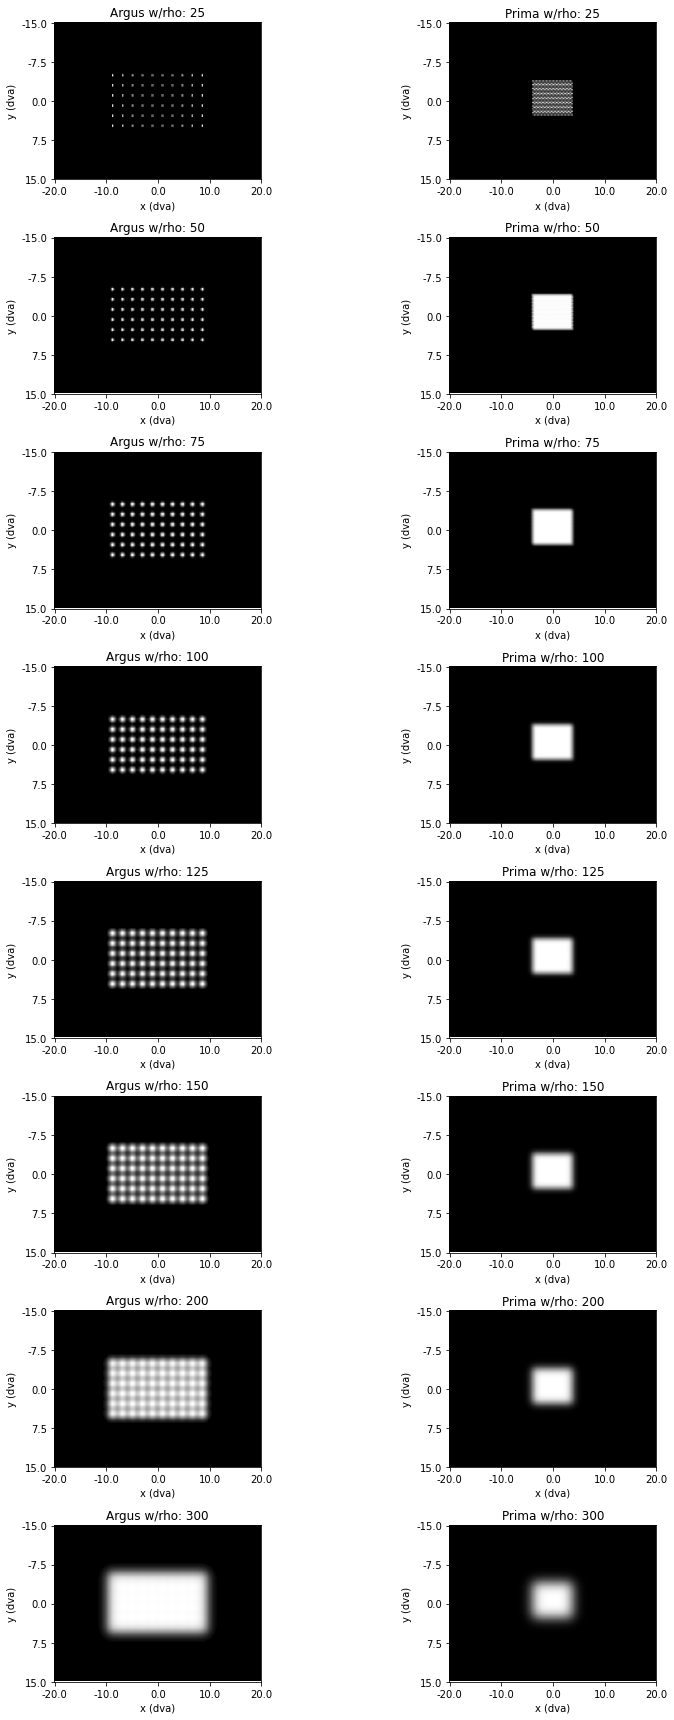

In [7]:
fig, axs = plt.subplots(len(rhos), 3, constrained_layout=False, figsize=(12, 3 * len(rhos)))

#
# PLOT THE ARGUS AND PRIMA IMPLANTS FOR VARIOUS VALUES OF RHO USING SCOREBOARD MODEL 
# SO THAT WE CAN VISUALIZE WHAT CHANGING VALUES FOR RHO DOES
#
for rho, (ax_argus, ax_prima, ax_prima_gauss) in zip(rhos, axs):
    model = p2p.models.ScoreboardModel(rho=rho)
    model.engine = 'serial'
    model.build()
    
    # simulate ArgusII
    print("rho: %d argus scoreboard" % rho)
    implant = p2p.implants.ArgusII()
    implant.stim = BASE_CURRENT_CONSTANT * np.ones(60)
    
    percept = model.predict_percept(implant)
    plot_percept(ax_argus, model, percept, "Argus w/rho: %d" % rho)
    
    # simulate Prima
    print("rho: %d prima scoreboard" % rho)
    implant = Prima()
    implant.stim = BASE_CURRENT_CONSTANT * np.ones(400)
    
    percept = model.predict_percept(implant)
    plot_percept(ax_prima, model, percept, "Prima w/rho: %d" % rho)

fig.tight_layout()

In [11]:
import gzip
import pickle 
import os 
#
# GENERATE DATASET OF PERCEPTS FROM THE ABOVE PLOTTING
# !! WARNING !! THIS WILL TAKE A VERY LONG TIME ON MOST CPUs
#
basedir = "./data/changing_rho_experiments/"
try:
    os.makedirs(basedir)
except: pass 

print("generating percept sets for values of rho: " + str(rhos))
for rho in rhos:
    model = p2p.models.ScoreboardModel(rho=rho)
    model.engine = 'serial'
    model.build()
    
    # simulate ArgusII
    print("rho: %d argus scoreboard" % rho)
    if not os.path.exists(os.path.join(basedir, "argus_scoreboard_rho%d.pickle.gz" % rho)):
        implant = p2p.implants.ArgusII()
        percepts = generate_dataset_fast(model, implant, 60, j=24)
        with gzip.open(os.path.join(basedir, "argus_scoreboard_rho%d.pickle.gz" % rho), "wb") as f:
            pickle.dump(percepts, f)
            
    # simulate AlphaIMS
    if rho in rhos_alpha:
        print("rho: %d alphaams scoreboard" % rho)
        if not os.path.exists(os.path.join(basedir, "alphaams_scoreboard_rho%d.pickle.gz" % rho)):
            implant = p2p.implants.AlphaAMS()
            percepts = generate_dataset_fast(model, implant, 40 ** 2, j=24)
            with gzip.open(os.path.join(basedir, "alphaams_scoreboard_rho%d.pickle.gz" % rho), "wb") as f:
                pickle.dump(percepts, f)

    
    # simulate Prima
    print("rho: %d prima scoreboard" % rho)
    if not os.path.exists(os.path.join(basedir, "prima_scoreboard_rho%d.pickle.gz" % rho)):
        implant = Prima()
        percepts = generate_dataset_fast(model, implant, 400, j=24)
        with gzip.open(os.path.join(basedir, "prima_scoreboard_rho%d.pickle.gz" % rho), "wb") as f:
            pickle.dump(percepts, f)


generating percept sets for values of rho: [25, 50, 75, 100, 125, 150, 200, 300]
rho: 25 argus scoreboard
rho: 25 prima scoreboard
rho: 50 argus scoreboard
rho: 50 alphaams scoreboard
rho: 50 prima scoreboard
rho: 75 argus scoreboard
rho: 75 prima scoreboard
rho: 100 argus scoreboard
rho: 100 alphaams scoreboard
rho: 100 prima scoreboard
rho: 125 argus scoreboard
rho: 125 prima scoreboard
rho: 150 argus scoreboard
rho: 150 alphaams scoreboard
rho: 150 prima scoreboard
rho: 200 argus scoreboard
rho: 200 alphaams scoreboard
rho: 200 prima scoreboard
rho: 300 argus scoreboard
rho: 300 alphaams scoreboard
rho: 300 prima scoreboard


In [12]:
import pickle
import os 
import gzip 
# 
# GENERATE PLOT OF THE PCA DAT
#
percent = 0.95

argus_pca_shapes = []
prima_pca_shapes = []
for rho in rhos:
    argus_percepts_path = os.path.join(basedir, "argus_scoreboard_rho%d.pickle.gz" % rho)
    prima_percepts_path = os.path.join(basedir, "prima_scoreboard_rho%d.pickle.gz" % rho)
    with gzip.open(argus_percepts_path, "rb") as f:
        argus_percepts = pickle.load(f)
    print("loaded argus percepts for rho %d, size: %s" % (rho, str(np.array(argus_percepts).shape)))
    with gzip.open(prima_percepts_path, "rb") as f:
        prima_percepts = pickle.load(f)
    print("loaded prima percepts for rho %d, size: %s" % (rho, str(np.array(prima_percepts).shape)))
    
    argus_pca_components, _ = run_pca(argus_percepts, percent)
    argus_pca_shapes.append(argus_pca_components.shape)
    print("\targus pca shape: " + str(argus_pca_components.shape))
    prima_pca_components, _ = run_pca(prima_percepts, percent)
    prima_pca_shapes.append(prima_pca_components.shape)
    print("\tprima pca shape: " + str(prima_pca_components.shape))

loaded argus percepts for rho 25, size: (60, 124, 164)
loaded prima percepts for rho 25, size: (400, 124, 164)
	argus pca shape: (60, 57)
	prima pca shape: (400, 378)
loaded argus percepts for rho 50, size: (60, 124, 164)
loaded prima percepts for rho 50, size: (400, 124, 164)
	argus pca shape: (60, 57)
	prima pca shape: (400, 332)
loaded argus percepts for rho 75, size: (60, 124, 164)
loaded prima percepts for rho 75, size: (400, 124, 164)
	argus pca shape: (60, 57)
	prima pca shape: (400, 175)
loaded argus percepts for rho 100, size: (60, 124, 164)
loaded prima percepts for rho 100, size: (400, 124, 164)
	argus pca shape: (60, 57)
	prima pca shape: (400, 103)
loaded argus percepts for rho 125, size: (60, 124, 164)
loaded prima percepts for rho 125, size: (400, 124, 164)
	argus pca shape: (60, 57)
	prima pca shape: (400, 68)
loaded argus percepts for rho 150, size: (60, 124, 164)
loaded prima percepts for rho 150, size: (400, 124, 164)
	argus pca shape: (60, 56)
	prima pca shape: (400

In [13]:
import pickle
import os 
import gzip 
# 
# GENERATE PLOT OF THE PCA DATA for alpha and argus
#
percent = 0.95

alpha_pca_shapes = []
prima_pca_shapes = []
basedir = "./data/changing_rho_experiments/"
try:
    os.makedirs(basedir)
except: pass 

for rho in rhos:
    alpha_percepts_path = os.path.join(basedir, "alphaams_scoreboard_rho%d.pickle.gz" % rho)
    prima_percepts_path = os.path.join(basedir, "prima_scoreboard_rho%d.pickle.gz" % rho)
    if rho in rhos_alpha:
        with gzip.open(alpha_percepts_path, "rb") as f:
            alpha_percepts = pickle.load(f)
        print("loaded alpha percepts for rho %d, size: %s" % (rho, str(np.array(alpha_percepts).shape)))
    
    
        alpha_pca_components, _ = run_pca(alpha_percepts, percent)
        alpha_pca_shapes.append(alpha_pca_components.shape)
        print("\talpha pca shape: " + str(alpha_pca_components.shape))
    with gzip.open(prima_percepts_path, "rb") as f:
        prima_percepts = pickle.load(f)
    print("loaded prima percepts for rho %d, size: %s" % (rho, str(np.array(prima_percepts).shape)))
    
    prima_pca_components, _ = run_pca(prima_percepts, percent)
    prima_pca_shapes.append(prima_pca_components.shape)
    print("\tprima pca shape: " + str(prima_pca_components.shape))

loaded prima percepts for rho 25, size: (400, 124, 164)
	prima pca shape: (400, 378)
loaded alpha percepts for rho 50, size: (1600, 124, 164)
	alpha pca shape: (1600, 775)
loaded prima percepts for rho 50, size: (400, 124, 164)
	prima pca shape: (400, 332)
loaded prima percepts for rho 75, size: (400, 124, 164)
	prima pca shape: (400, 175)
loaded alpha percepts for rho 100, size: (1600, 124, 164)
	alpha pca shape: (1600, 205)
loaded prima percepts for rho 100, size: (400, 124, 164)
	prima pca shape: (400, 103)
loaded prima percepts for rho 125, size: (400, 124, 164)
	prima pca shape: (400, 68)
loaded alpha percepts for rho 150, size: (1600, 124, 164)
	alpha pca shape: (1600, 95)
loaded prima percepts for rho 150, size: (400, 124, 164)
	prima pca shape: (400, 49)
loaded alpha percepts for rho 200, size: (1600, 124, 164)
	alpha pca shape: (1600, 57)
loaded prima percepts for rho 200, size: (400, 124, 164)
	prima pca shape: (400, 30)
loaded alpha percepts for rho 300, size: (1600, 124, 16

prima shapes,  [378, 332, 175, 103, 68, 49, 30, 15]
alpha shapes,  [775, 205, 95, 57, 28]


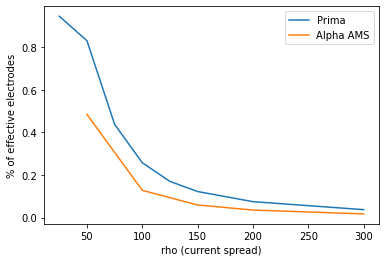

In [22]:
print("prima shapes, ", [v[1] for v in prima_pca_shapes])
print("alpha shapes, ", [v[1] for v in alpha_pca_shapes])
plt.plot(rhos, [v[1]/400 for v in prima_pca_shapes], label="Prima")
plt.plot(rhos_alpha, [v[1]/1600 for v in alpha_pca_shapes],label = "Alpha AMS")
plt.ylabel("% of effective electrodes")
plt.xlabel("rho (current spread)")
# plt.title("Prima vs. Alpha AMS: PCA Components With Changing Rho")
plt.legend()

prima shapes,  [378, 332, 175, 103, 68, 49, 30, 15]
alpha shapes,  [775, 205, 95, 57, 28]


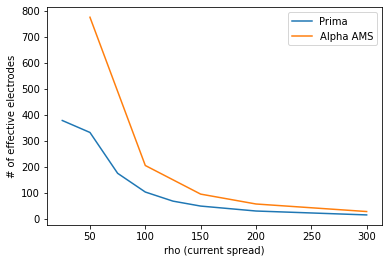

In [21]:
print("prima shapes, ", [v[1] for v in prima_pca_shapes])
print("alpha shapes, ", [v[1] for v in alpha_pca_shapes])
plt.plot(rhos, [v[1] for v in prima_pca_shapes], label="Prima")
plt.plot(rhos_alpha, [v[1] for v in alpha_pca_shapes],label = "Alpha AMS")
plt.ylabel("# of effective electrodes")
plt.xlabel("rho (current spread)")
# plt.title("Prima vs. Alpha AMS: PCA Components With Changing Rho")
plt.legend()

prima shapes,  [378, 332, 175, 103, 68, 49, 30, 15]
argus shapes,  [57, 57, 57, 57, 57, 56, 54, 44]


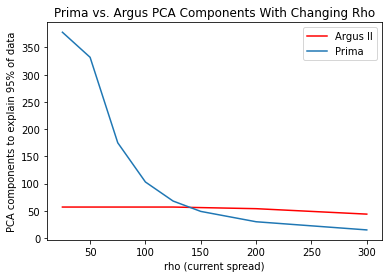

In [16]:
print("prima shapes, ", [v[1] for v in prima_pca_shapes])
print("argus shapes, ", [v[1] for v in argus_pca_shapes])
plt.plot(rhos, [v[1] for v in argus_pca_shapes], 'r', rhos, [v[1] for v in prima_pca_shapes])
plt.ylabel("PCA components to explain 95% of data")
plt.xlabel("rho (current spread)")
plt.title("Prima vs. Argus PCA Components With Changing Rho")
plt.legend(("Argus II", "Prima"))

In [17]:
import pickle
import os 
import gzip 
# 
# GENERATE PLOT OF THE PCA DATA W/AXONMAP
#
percent = 0.95

argus_pca_shapes = []
prima_pca_shapes = []
for rho in rhos:
    argus_percepts_path = os.path.join(basedir, "argus_scoreboard_rho%d.pickle.gz" % rho)
    prima_percepts_path = os.path.join(basedir, "prima_scoreboard_rho%d.pickle.gz" % rho)
    with gzip.open(argus_percepts_path, "rb") as f:
        argus_percepts = pickle.load(f)
    print("loaded argus percepts for rho %d, size: %s" % (rho, str(np.array(argus_percepts).shape)))
    with gzip.open(prima_percepts_path, "rb") as f:
        prima_percepts = pickle.load(f)
    print("loaded prima percepts for rho %d, size: %s" % (rho, str(np.array(prima_percepts).shape)))
    
    argus_pca_components, _ = run_pca(argus_percepts, percent)
    argus_pca_shapes.append(argus_pca_components.shape)
    print("\targus pca shape: " + str(argus_pca_components.shape))
    prima_pca_components, _ = run_pca(prima_percepts, percent)
    prima_pca_shapes.append(prima_pca_components.shape)
    print("\tprima pca shape: " + str(prima_pca_components.shape))

loaded argus percepts for rho 25, size: (60, 124, 164)
loaded prima percepts for rho 25, size: (400, 124, 164)
	argus pca shape: (60, 57)
	prima pca shape: (400, 378)
loaded argus percepts for rho 50, size: (60, 124, 164)
loaded prima percepts for rho 50, size: (400, 124, 164)
	argus pca shape: (60, 57)
	prima pca shape: (400, 332)
loaded argus percepts for rho 75, size: (60, 124, 164)
loaded prima percepts for rho 75, size: (400, 124, 164)
	argus pca shape: (60, 57)
	prima pca shape: (400, 175)
loaded argus percepts for rho 100, size: (60, 124, 164)
loaded prima percepts for rho 100, size: (400, 124, 164)
	argus pca shape: (60, 57)
	prima pca shape: (400, 103)
loaded argus percepts for rho 125, size: (60, 124, 164)
loaded prima percepts for rho 125, size: (400, 124, 164)
	argus pca shape: (60, 57)
	prima pca shape: (400, 68)
loaded argus percepts for rho 150, size: (60, 124, 164)
loaded prima percepts for rho 150, size: (400, 124, 164)
	argus pca shape: (60, 56)
	prima pca shape: (400

In [18]:
print("helo world")

helo world


In [ ]:
##Dataset for scoreboard model for Alpha

# Gaussian Blur Prima Experiments

In [ ]:
model = p2p.models.ScoreboardModel(rho=rho)
model.engine = 'serial'
model.build()

sigma: 0.00 prima scoreboard
sigma: 0.50 prima scoreboard
sigma: 1.00 prima scoreboard
sigma: 1.50 prima scoreboard


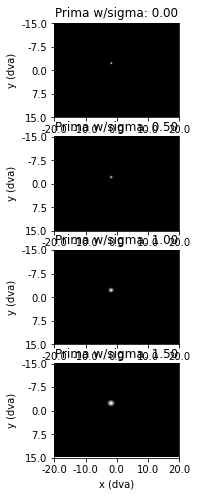

In [27]:
# simulate Prima w/blur for vraious values of sigma
rho = 50
sigmas = [0, 0.5, 1., 1.5]
fig, axs = plt.subplots(len(sigmas), 1, constrained_layout=False, figsize=(3, 2 * len(sigmas)))

# with Pool(j) as p:
#     generator = p.imap(generate_dataset_helper, [(model, implant, stim_dim, idx) for idx in range(0, stim_dim)])
#     return list(tqdm(generator, total=stim_dim))

def sim_sigma_helper(stim):
    implant = Prima()
    implant.stim = stim
    
    percept = model.predict_percept(implant)
    
    return percept 

with Pool(24) as p:
    stims = []
    for sigma in sigmas:
        stim = np.zeros(400).reshape((20, 20))
        stim[5, 5] = BASE_CURRENT_CONSTANT * 4 
        stim = gaussian_filter(stim, sigma=sigma)
        stim = stim.flatten()
        stims.append(stim)
    
    generator = p.imap(sim_sigma_helper, stims)
    for ax, percept, sigma in zip(axs, generator, sigmas):
        print("sigma: %.2f prima scoreboard" % sigma)
        plot_percept(ax, model, percept, "Prima w/sigma: %.2f" % sigma)

In [37]:
# generate dataset
import os
import gzip 
import pickle 

rho = 50
sigmas = [0, 0.5, 1., 1.5]

def sim_sigma_helper(stim):
    implant = Prima()
    implant.stim = stim
    percept = model.predict_percept(implant)
    return percept 

with Pool(24) as p:
    basedir = "./data/changing_sigma_experiments/"
    try:
        os.makedirs(basedir)
    except: pass 

    print("generating percept sets for values of sigma: " + str(sigmas))
    for sigma in sigmas:
        model = p2p.models.ScoreboardModel(rho=rho)
        model.engine = 'serial'
        model.build()

        # simulate Prima
        print("sigma: %.2f prima scoreboard" % sigma)
        if not os.path.exists(os.path.join(basedir, "prima_scoreboard_sigma%.2f.pickle.gz" % sigma)):
            implant = Prima()
            
            stims = []
            for x in range(0, 400):
                stim = np.zeros(400)
                stim[x] = BASE_CURRENT_CONSTANT * 4 
                stim = stim.reshape((20, 20))
                stim = gaussian_filter(stim, sigma=sigma)
                stim = stim.flatten()

                stims.append(stim)
                
            percepts = list(tqdm(p.imap(sim_sigma_helper, stims)))
            
            with gzip.open(os.path.join(basedir, "prima_scoreboard_sigma%.2f.pickle.gz" % sigma), "wb") as f:
                pickle.dump(percepts, f)

0it [00:00, ?it/s]

generating percept sets for values of sigma: [0, 0.5, 1.0, 1.5]
sigma: 0.00 prima scoreboard


400it [13:12,  1.98s/it]


sigma: 0.50 prima scoreboard
sigma: 1.00 prima scoreboard
sigma: 1.50 prima scoreboard
